In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0604.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0868.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a1012.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/c0445.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/u0030.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/r0229.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/n0503.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/za0739.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/m0348.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/zc0313.png
/kaggle/input/driver-drowsin

In [3]:
!pip install opencv-python 


In [5]:
import cv2
import random

In [6]:
main_path = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/'
drowsy = [os.path.join(main_path, 'Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Drowsy'))]
non_drowsy = [os.path.join(main_path, 'Non Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Non Drowsy'))]
all_images=drowsy+non_drowsy

In [9]:
random.shuffle(all_images)
def extract_class_name(p):
    return p.split('/')[-2] 

In [40]:
random_image_path = random.choice(all_images)
print("Random Image Path:", random_image_path)


Random Image Path: /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/w0240.png


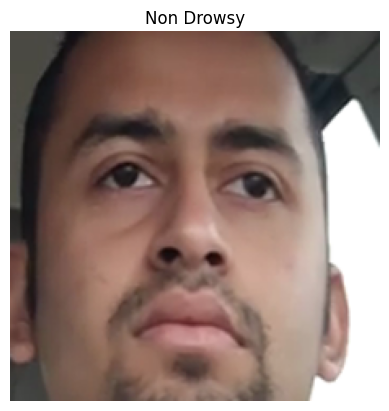

In [43]:
# Load the image
image = cv2.imread(random_image_path)

# Convert from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = extract_class_name(random_image_path)
# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis labels
plt.title(label)
plt.show()



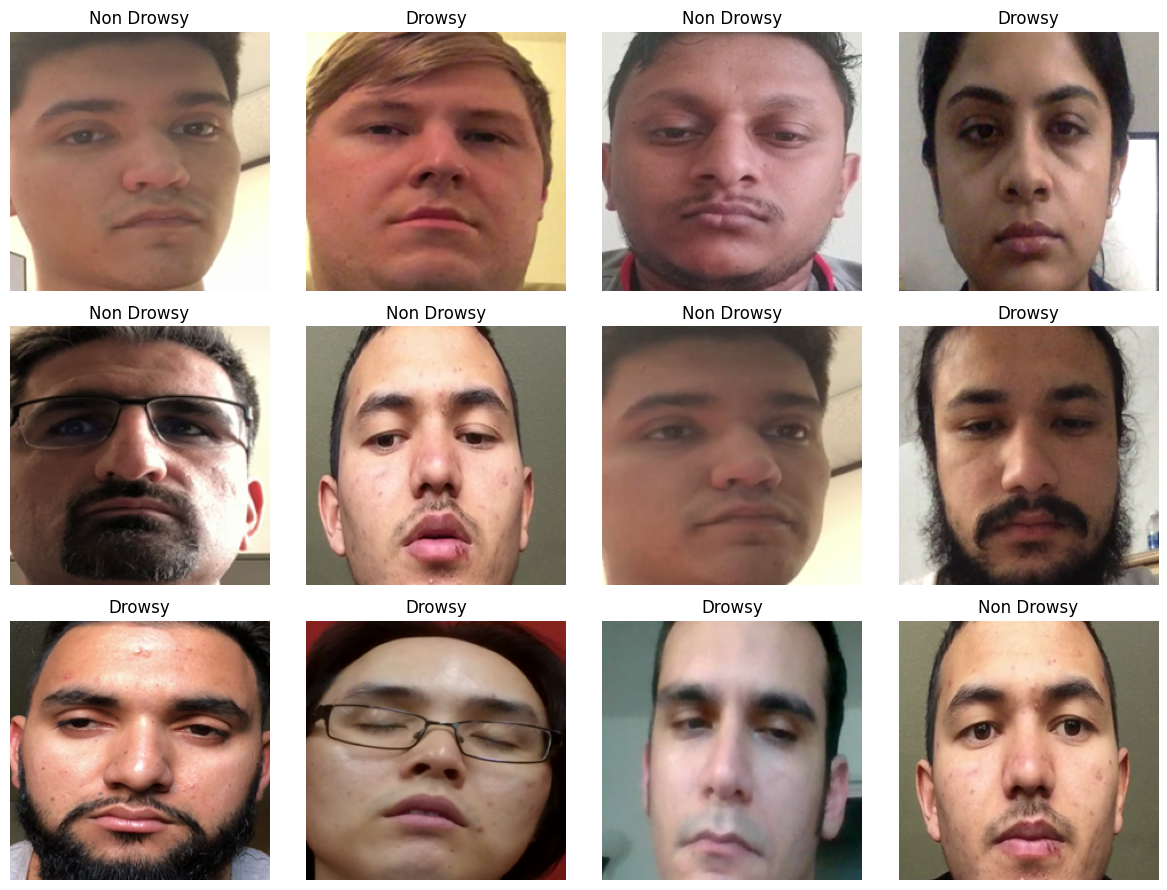

In [11]:
from matplotlib import pyplot as plt

num_images = 12
grid_size = (3, 4)  

# Create a grid of subplots
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 9))  # Adjust `figsize` for better layout
axes = axes.ravel()  # Flatten the 2D array of axes into a 1D array

for i in range(num_images):
    # Select a random image
    random_image_path = random.choice(all_images)
    image = cv2.imread(random_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = extract_class_name(random_image_path)  # Extract the label (assumes you have this function)
    
    # Plot the image in the grid
    axes[i].imshow(image_rgb)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(label)  # Add the label as the title

# Remove any extra subplots if less than total images
for j in range(num_images, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from transformers import DeiTForImageClassification, DeiTImageProcessor
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [13]:
class DrowsinessDataset(Dataset):
    def __init__(self, image_paths, labels, processor, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        if self.transform:
            image = self.transform(image)
        
        # Process the image for DeiT model
        inputs = self.processor(images=image, return_tensors="pt")
        
        return inputs['pixel_values'].squeeze(), label

In [14]:
# Train-test-validation split
labels = [extract_class_name(p) for p in all_images]
labels = [0 if label == 'Non Drowsy' else 1 for label in labels]  # 0 for Non Drowsy, 1 for Drowsy



In [19]:
import torch
from torch import nn, optim
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/f

In [20]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])


In [23]:
class DrowsinessDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format
        
        label = 0 if 'Non Drowsy' in img_path else 1  # Class: 0 = Non-Drowsy, 1 = Drowsy
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [24]:
# Split into train, validation, test (80% train, 10% validation, 10% test)
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.1, random_state=42)

# Create datasets
train_dataset = DrowsinessDataset(train_images, transform)
val_dataset = DrowsinessDataset(val_images, transform)
test_dataset = DrowsinessDataset(test_images, transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
# Print the size of the splits
print(f"Train set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Train set size: 30090
Validation set size: 3344
Test set size: 8359


In [25]:
import torch.optim as optim
from torch import nn

# Load the model (deit_tiny)
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# Modify the last layer for binary classification
model.head = nn.Linear(model.head.in_features, 2)  # 2 output classes:

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


In [26]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [27]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    avg_loss = running_loss / len(train_loader)
    return avg_loss, accuracy

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_loss = running_loss / len(val_loader)
    return avg_loss, accuracy

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [32]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [34]:
import multiprocessing

# Set multiprocessing start method to 'spawn'
multiprocessing.set_start_method('spawn', force=True)


In [35]:
import os
os.environ['JAX_NUM_THREADS'] = '1'
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)  # Use num_workers=0
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)


In [36]:
epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    
    model.eval()  # Set the model to evaluation mode
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    # Store the losses and accuracies for plotting later
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print the results for this epoch
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%")


Epoch 1/5
Train Loss: 0.0094, Train Accuracy: 99.68%
Val Loss: 0.0033, Val Accuracy: 99.97%
Epoch 2/5
Train Loss: 0.0013, Train Accuracy: 99.97%
Val Loss: 0.0022, Val Accuracy: 99.97%
Epoch 3/5
Train Loss: 0.0049, Train Accuracy: 99.85%
Val Loss: 0.0026, Val Accuracy: 99.97%
Epoch 4/5
Train Loss: 0.0023, Train Accuracy: 99.93%
Val Loss: 0.0051, Val Accuracy: 99.76%
Epoch 5/5
Train Loss: 0.0048, Train Accuracy: 99.84%
Val Loss: 0.0208, Val Accuracy: 99.73%


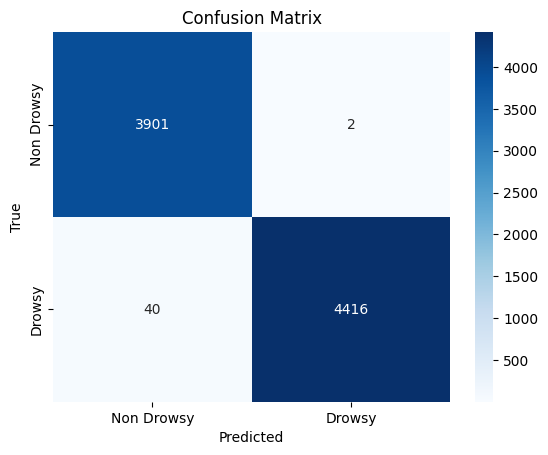

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3903
           1       1.00      0.99      1.00      4456

    accuracy                           0.99      8359
   macro avg       0.99      1.00      0.99      8359
weighted avg       1.00      0.99      0.99      8359



In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

test_labels, test_preds = evaluate(model, test_loader, device)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Drowsy', 'Drowsy'], yticklabels=['Non Drowsy', 'Drowsy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [38]:
# Classification Report (includes F1 score)
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3903
           1       1.00      0.99      1.00      4456

    accuracy                           0.99      8359
   macro avg       0.99      1.00      0.99      8359
weighted avg       1.00      0.99      0.99      8359



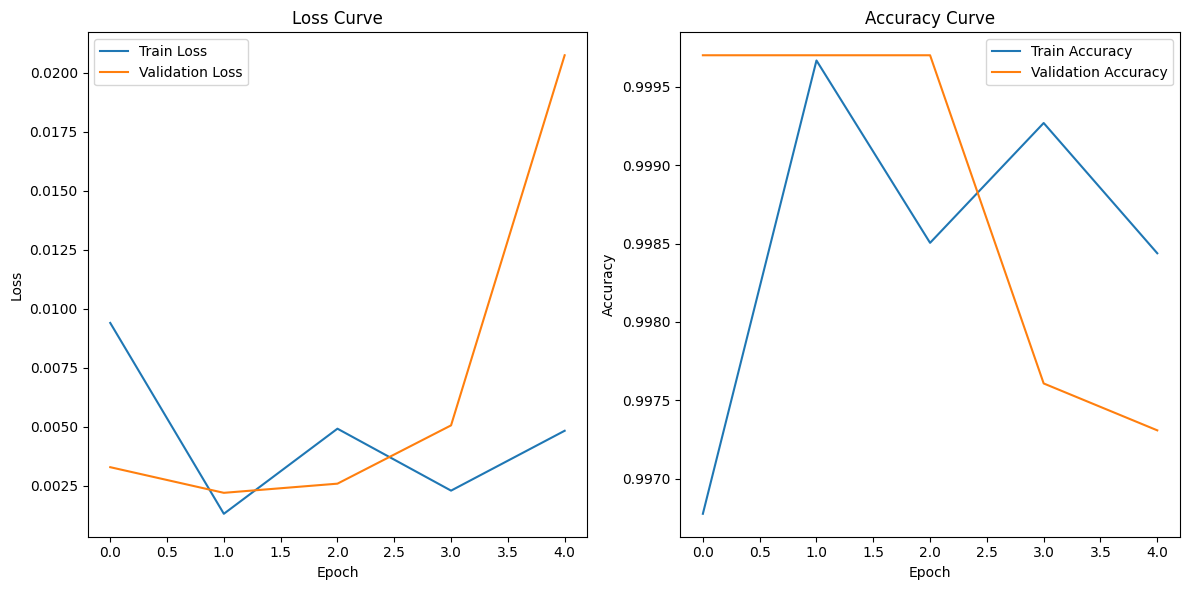

In [39]:
# Plot Loss Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
